In [ ]:
## 2024.03.11 월요일 02:32AM

In [2]:
# 코랩을 사용할 때는 다음 셀의 주석을 제거하고 실행하세요.
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2024-03-10 18:11:39--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz.1’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2024-03-10 18:11:39 (86.9 MB/s) - ‘train-images-idx3-ubyte.gz.1’ saved [9912422/9912422]

--2024-03-10 18:11:39--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz.1’

train-labels-idx1-u 100%[=====

In [3]:
## MNIST Data 압축 해제 Code

import sys
import gzip
import shutil
import os

if (sys.version_info > (3, 0)):
  writemode = 'wb'
else:
  writemode = 'w'

zipped_mnist = [f for f in os.listdir() if f.endswith('ubyte.gz')]
for z in zipped_mnist:
  with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
    outfile.write(decompressed.read())

In [4]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
  labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
  images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

  with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II', lbpath.read(8))
    labels = np.fromfile(lbpath, dtype=np.uint8)

  with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))

    images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    images = ((images / 255.) - .5) * 2

  return images, labels

In [5]:
!ls

sample_data		     t10k-labels-idx1-ubyte.gz	   train-labels-idx1-ubyte
t10k-images-idx3-ubyte	     t10k-labels-idx1-ubyte.gz.1   train-labels-idx1-ubyte.gz
t10k-images-idx3-ubyte.gz    train-images-idx3-ubyte	   train-labels-idx1-ubyte.gz.1
t10k-images-idx3-ubyte.gz.1  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	     train-images-idx3-ubyte.gz.1


In [6]:
X_train, y_train = load_mnist('', kind='train')
print('행: %d, 열: %d' % (X_train.shape[0], X_train.shape[1]))

행: 60000, 열: 784


In [7]:
X_test, y_test = load_mnist('', kind='t10k')
print('행: %d, 열: %d' % (X_test.shape[0], X_test.shape[1]))

행: 10000, 열: 784


In [8]:
## 다층 퍼셉트론 구현(= MLP 구현)
import numpy as np
import sys

class NeuralNetMLP(object):
  """피드포워드 신경망 / 다층 퍼셉트론 분류기

  매개변수(parameter)
  --------------------
  n_hidden : int (기본값: 30)
             은닉 유닛 개수

  l2 : float (기본값: 0.)
       L2 규제의 람다 값
       l2=0이면 규제없음. (기본값)

  epochs : int (기본값: 100)
           훈련 데이터셋을 반복할 횟수

  eta : float (기본값: 0.001)
        학습률

  shuffle : bool (기본값: True)
            에포크마다 훈련 데이터셋을 섞을지 여부
            True면 데이터를 섞어 순서를 바꾼다.

  minibatch_size : int (기본값: 1)
                   미니 배치의 훈련샘플 개수

  seed : int (기본값: None)
         가중치와 데이터 셔플링을 위한 난수 초깃값

  속성
  -----------
  eval_ : dict
          훈련 에포크마다 비용, 훈련 정확도, 검증 정확도를 수집하기 위한 dictionary
  """
  def __init__(self, n_hidden=30,
               l2=0., epochs=100, eta=0.001,
               shuffle=True, minibatch_size=1, seed=None):

    self.random = np.random.RandomState(seed)
    self.n_hidden = n_hidden
    self.l2 = l2
    self.epochs = epochs
    self.eta = eta
    self.shuffle = shuffle
    self.minibatch_size = minibatch_size


  def _onehot(self, y, n_classes):
    """ 레이블을 원-핫 방식으로 인코딩한다.

    매개변수(parameter)
    --------------------
    y : 배열, 크기 = [n_samples]
        타깃 값

    반환값
    ------------
    onehot : 배열, 크기 = (n_samples, n_labels)
    """
    onehot = np.zeros((n_classes, y.shape[0]))
    for idx, val in enumerate(y.astype(int)):
      onehot[val, idx] = 1.
    return onehot.T


  def _sigmoid(self, z):
    """로지스틱 함수(시그모이드)를 계산한다."""
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))


  def _forward(self, X):
    """정방향 계산을 수행한다.(순전파 <-> 역전파)"""

    # 단계 1: 은닉층의 최종 입력
    # [n_samples, n_features] dot [n_features, n_hidden]
    # -> [n_samples, n_hidden]
    z_h = np.dot(X, self.w_h) + self.b_h

    # 단계 2: 은닉층의 활성화 출력
    a_h = self._sigmoid(z_h)

    # 단계 3: 출력층의 최종 입력
    # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
    # -> [n_samples, n_classlabels]
    z_out = np.dot(a_h, self.w_out) + self.b_out

    # 단계 4: 출력층의 활성화 출력
    a_out = self._sigmoid(z_out)

    return z_h, a_h, z_out, a_out


  def _compute_cost(self, y_enc, output):
    """ 비용 함수를 계산한다. cost fuction

    매개변수(parameter)
    ---------------------
    y_enc : 배열, 크기 = (n_samples, n_labels)
            원-핫 인코딩된 클래스 레이블

    output : 배열, 크키 = [n_samples, n_output_units]
             출력층의 활성화 출력(정방향 계산)

    반환값
    --------
    cost : float
           규제가 포함된 내용
    """
    L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))

    term1 = -y_enc * (np.log(output))
    term2 = (1. - y_enc) * np.log(1. - output)
    cost = np.sum(term1 - term2) + L2_term
    return cost


  def predict(self, X):
    """ 클래스 레이블을 예측한다.

    매개변수(parameter)
    ---------------------
    X : 배열, 크기 = [n_samples, n_features]
        원본 특성의 입력층

    반환값
    --------
    y_pred : 배열, 크기 = [n_samples]
             예측된 클래스 레이블
    """
    z_h, a_h, z_out, a_out = self._forward(X)
    y_pred = np.argmax(z_out, axis=1)
    return y_pred


  def fit(self, X_train, y_train, X_valid, y_valid):
    """ 훈련 데이터에서 가중치를 학습한다.

    매개변수(= 파라미터)
    ---------------------
    X_train : 배열, 크기 = [n_samples, n_features]
              원본 특성의 input layer

    y_train : 배열, 크기 = [n_samples]
              타깃 클래스 레이블

    X_valid : 배열, 크기 = [n_samples, n_features]
              훈련하는 동안 검증에 사용할 샘플 특성

    y_valid : 배열, 크기 = [n_samples]
              훈련하는 동안 검증에 사용할 샘플 Label

    return값
    ---------
    self

    """
    n_output = np.unique(y_train).shape[0] # class label 개수
    n_features = X_train.shape[1]

    ######################
    # 가중치 초기화
    #####################

    # 입력층 -> 은닉층 사이의 가중치
    self.b_h = np.zeros(self.n_hidden)
    self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))

    # 은닉층 -> 출력층 사이의 가중치
    self.b_out = np.zeros(n_output)
    self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))

    epoch_strlen = len(str(self.epochs)) # 출력 포맷을 위해
    self.eval_ = {'cost':[], 'train_acc':[], 'valid_acc':[]}
    y_train_enc = self._onehot(y_train, n_output)

    # 훈련 에포크를 반복한다.
    for i in range(self.epochs):

      # mini-batch로 반복한다.
      indices = np.arange(X_train.shape[0])

      if self.shuffle:
        self.random.shuffle(indices)

      for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
        batch_idx = indices[start_idx:start_idx + self.minibatch_size]

        # 정방향 계산
        z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

        #############
        # 역전파
        #############

        # [n_samples, n_classlabels]
        delta_out = a_out - y_train_enc[batch_idx]

        # [n_sampels, n_hidden]
        sigmoid_derivative_h = a_h * (1. - a_h)

        # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
        # -> [n_samples, n_hidden]
        delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h)

        # [n_features, n_samples] dot [n_samples, n_hidden]
        # -> [n_features, n_hidden]
        grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
        grad_b_h = np.sum(delta_h, axis=0)

        # [n_hidden, n_samples] dot [n_samples, n_classlabels]
        # -> [n_hidden, n_classlabels]
        grad_w_out = np.dot(a_h.T, delta_out)
        grad_b_out = np.sum(delta_out, axis=0)

        # 규제와 가중치 업데이트
        delta_w_h = (grad_w_h + self.l2*self.w_h)
        delta_b_h = grad_b_h    # 편향은 규제하지 않는다.
        self.w_h -= self.eta * delta_w_h
        self.b_h -= self.eta * delta_b_h

        delta_w_out = (grad_w_out + self.l2*self.w_out)
        delta_b_out = grad_b_out # 편향은 규제하지 않는다.
        self.w_out -= self.eta * delta_w_out
        self.b_out -= self.eta * delta_b_out

      ##########
      # 평가
      #########

      # 훈련하는 동안 에포크마다 평가한다.
      z_h, a_h, z_out, a_out = self._forward(X_train)

      cost = self._compute_cost(y_enc=y_train_enc, output=a_out)

      y_train_pred = self.predict(X_train)
      y_valid_pred = self.predict(X_valid)

      train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
      valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])

      sys.stderr.write('\r%0*d/%d  |  비용: %.2f'
                       '| 훈련/검증 정확도: %.2f%%/%.2f%% ' % (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
      sys.stderr.flush()

      self.eval_['cost'].append(cost)
      self.eval_['train_acc'].append(train_acc)
      self.eval_['valid_acc'].append(valid_acc)

    return self

In [9]:
## 나중에 값 변경하고 싶을때, 쉽게 바꾸려고
n_epochs = 200

In [10]:
pip install "numpy<1.24"

In [11]:
nn = NeuralNetMLP(n_hidden=100,
                  l2=0.01,
                  epochs=n_epochs,
                  eta=0.0005,
                  minibatch_size=100,
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000],
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

<ipython-input-8-e296ee45ffb9>:241: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
<ipython-input-8-e296ee45ffb9>:242: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
200/200 

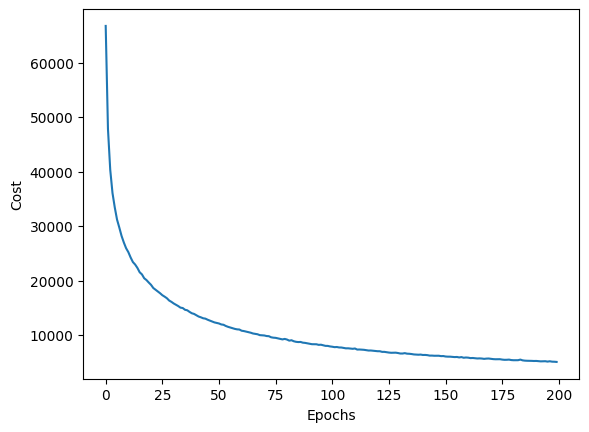

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

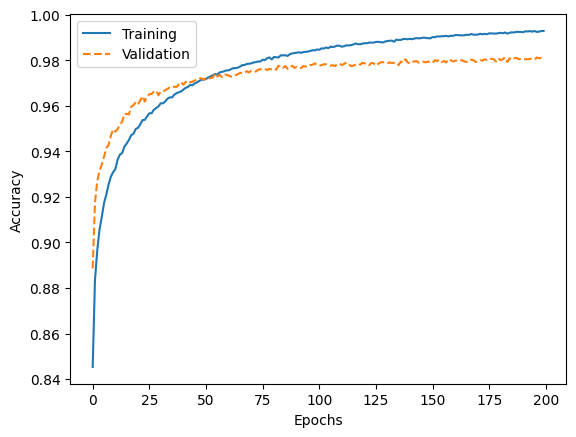

In [13]:
## 500p 훈련 정확도와 검증 정확도
## MNIST 데이터셋에서 훈련한 MLP의 정확도
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [14]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])
print('테스트 정확도: %.2f%%' % (acc * 100))

테스트 정확도: 97.54%


<ipython-input-14-2bdfcf12b83c>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])


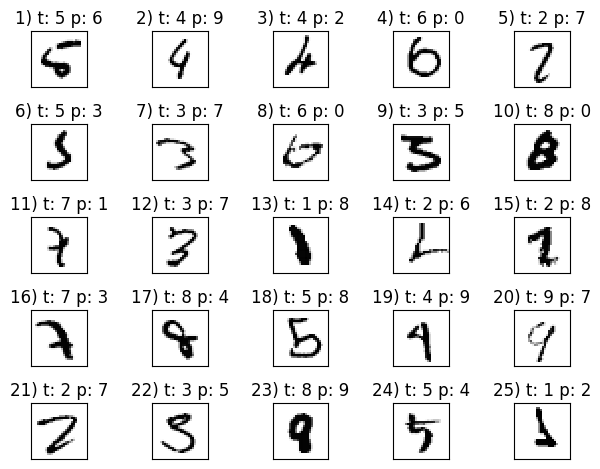

In [16]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex=True,
                       sharey=True,)

ax = ax.flatten()
for i in range(25):
  img = miscl_img[i].reshape(28, 28)
  ax[i].imshow(img,
               cmap='Greys',
               interpolation='nearest')
  ax[i].set_title('%d) t: %d p: %d'
                  % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [17]:
print(miscl_img)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


In [18]:
print(correct_lab)

[5 4 4 6 2 5 3 6 3 8 7 3 1 2 2 7 8 5 4 9 2 3 8 5 1]


In [19]:
print(miscl_lab)

[6 9 2 0 7 3 7 0 5 0 1 7 8 6 8 3 4 8 9 7 7 5 9 4 2]
